# Basic Imports

In [1]:
from __future__ import print_function, division
import logging
reload(logging)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s.%(msecs).03d %(name)s %(message)s",
    datefmt='%Y-%m-%dT%H:%M:%S'
)

In [2]:
%matplotlib inline

In [3]:
import pandas
import numpy
from matplotlib import pylab
import seaborn

# Import Sequencing Data

Selection data needs to be formatted as a "list of dicts" representing each round of selection. This structure is of the form:

````
{ name : # Name of the selection round.
    {
        "parent" : # Name of parent population, if selection was performed, else None
        "selection_level" : # Protease level, if selection was performend, else None
        "fraction_sampled" : # Optional, fraction of population collected during sort, else None
        "selected" : # Integer counts of # of cells selected in round. Derived from sequence data.
    }
}
````

In [4]:
chymo_fit_data = pandas.read_csv("161005_grocklin_chymo_fit_data", delim_whitespace=True)
chymo_src_data = (
    pandas.read_csv("161003_grocklin_chymo_data", delim_whitespace=True)
    .rename(columns={"chymo%s" % i : "rd%s" % i for i in range(1, 7)}))

#seq_counts & num_selected will be used to infer cell counts during selection
chymo_pop_data = {
    "rd0" : dict(seq_counts = chymo_src_data["rd0"], parent = None,  selection_level=None, num_selected=1.5e6, fraction_sampled = None),
    "rd1" : dict(seq_counts = chymo_src_data["rd1"], parent = "rd0", selection_level=1,    num_selected=1.5e6, fraction_sampled = None),
    "rd2" : dict(seq_counts = chymo_src_data["rd2"], parent = "rd0", selection_level=2,    num_selected=540e3, fraction_sampled = None),
    "rd3" : dict(seq_counts = chymo_src_data["rd3"], parent = "rd2", selection_level=3,    num_selected=640e3, fraction_sampled = .46),
    "rd4" : dict(seq_counts = chymo_src_data["rd4"], parent = "rd2", selection_level=4,    num_selected=52e3,  fraction_sampled = .039),
    "rd5" : dict(seq_counts = chymo_src_data["rd5"], parent = "rd4", selection_level=5,    num_selected=114e3, fraction_sampled = .048),
    "rd6" : dict(seq_counts = chymo_src_data["rd6"], parent = "rd4", selection_level=6,    num_selected=63e3,  fraction_sampled = .026),
}

for k, v in chymo_pop_data.items():
    pfrac = v["seq_counts"].values.astype(float) / v['seq_counts'].sum()
    v["selected"] = numpy.floor(pfrac * v["num_selected"])

# Generate Model and fit MAP

In [5]:
import protease_sequencing_model

In [6]:
chymo_model = (
    protease_sequencing_model.FractionalSelectionModel()
    .build_model(chymo_pop_data))

Applied interval-transform to sel_k and added transformed sel_k_interval_ to model.
Applied interval-transform to sel_ec50 and added transformed sel_ec50_interval_ to model.


In [7]:
default_map = chymo_model.find_MAP()

In [8]:
chymo_model.logp(default_map)

array(-437822.1295950188)

In [9]:
default_map

{'sel_ec50': array([ 3.02521813,  1.35703331,  3.01536747, ...,  0.23701118,
         2.5742819 ,  3.38145662]), 'sel_k': array(4.518210885298142)}

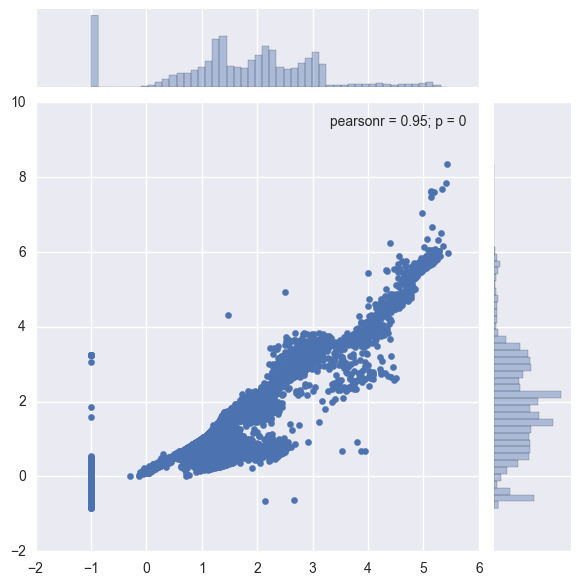

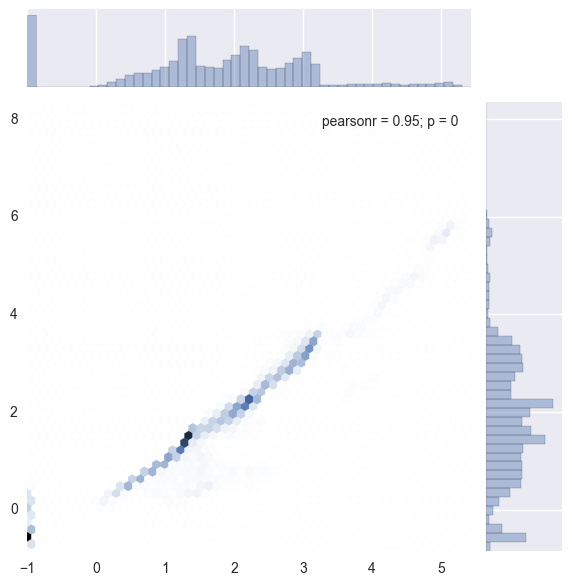

In [10]:
seaborn.jointplot(chymo_fit_data["ec50"].values, default_map["sel_ec50"])
seaborn.jointplot(chymo_fit_data["ec50"].values, default_map["sel_ec50"], kind="hex")

# Fit from alternate start estimates

Model MAP optimization converges on different values depending on initialization values. The majority of this variance is limited to a small number of decoys, the majority converge to nearly identical fit values.

In [11]:
alt_map = chymo_model.find_MAP({"sel_ec50" : default_map["sel_ec50"] + .5 })

In [12]:
chymo_model.logp(alt_map)

array(-373183.10674311034)

In [13]:
alt_map

{'sel_ec50': array([ 3.03503395,  1.36960034,  3.01219347, ...,  0.39776745,
         2.65291774,  3.35832686]), 'sel_k': array(5.574710468321262)}

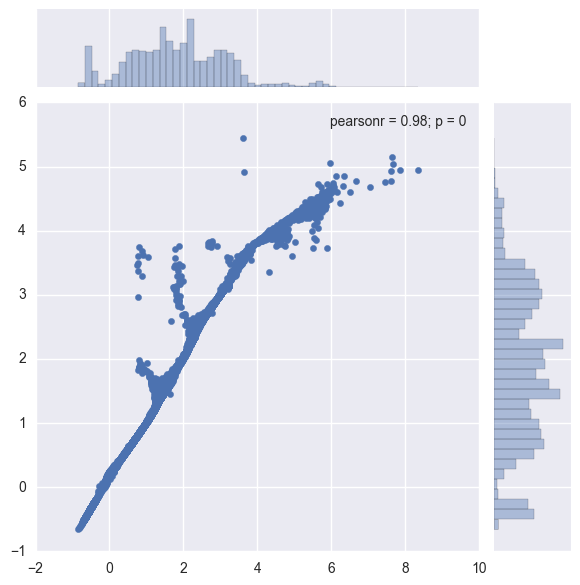

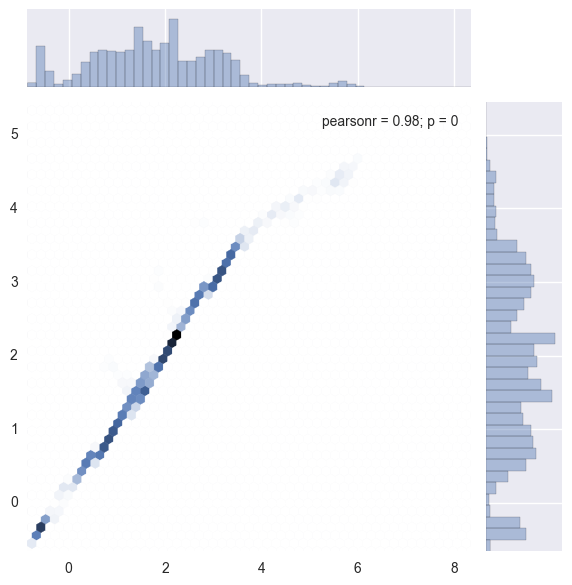

In [14]:
seaborn.jointplot(default_map['sel_ec50'], alt_map["sel_ec50"])
seaborn.jointplot(default_map['sel_ec50'], alt_map["sel_ec50"], kind="hex")

# Estimate sample ec50 credible intervals

,name,sequence,rd0,rd1,rd2,rd3,rd4,rd5,rd6
12478,EEHEE_rd3_0846.pdb_PG_hp,GDFTYGHTHAEAPTPTVVLHYANEYLQNEKVPVNVNGTEVKVK,24,3,7,22,0,0,0
5081,EEHEE_rd3_1582.pdb_PG_hp,NNVEAGHYKAQAPTPEKVANFVNEILTKIKGKITVKTGHITFT,39,1,1,0,0,0,0
9823,EEHEE_rd3_1646.pdb,GTVHVGDFTYQAPTPEKAQKLAKIAAKIYGLEVHIEGNEITLK,41,9,4,0,0,0,0
2484,HEEH_rd3_1654.pdb_PG_hp,EPTLESIVNQAQKDTVHRAQAKGINAEIEEPKKLADLAETLVE,41,5,21,59,0,0,0


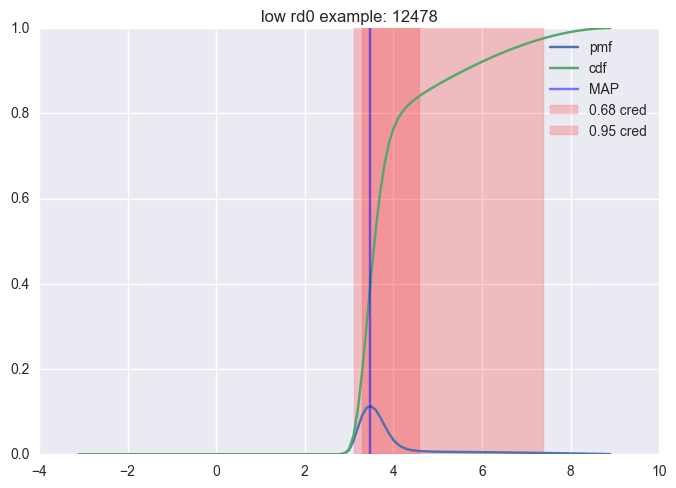

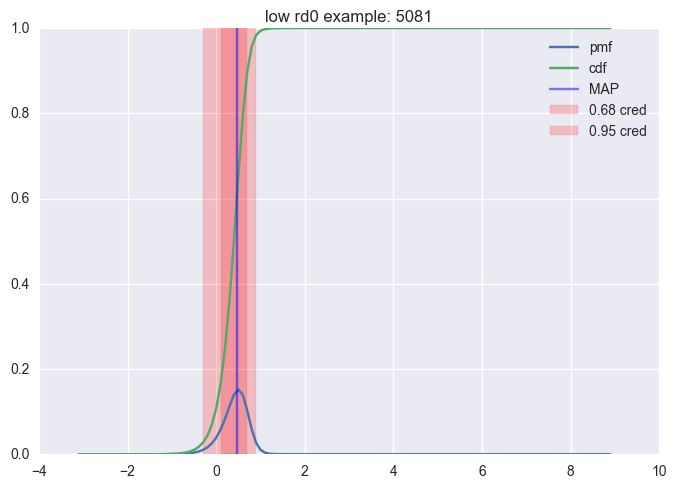

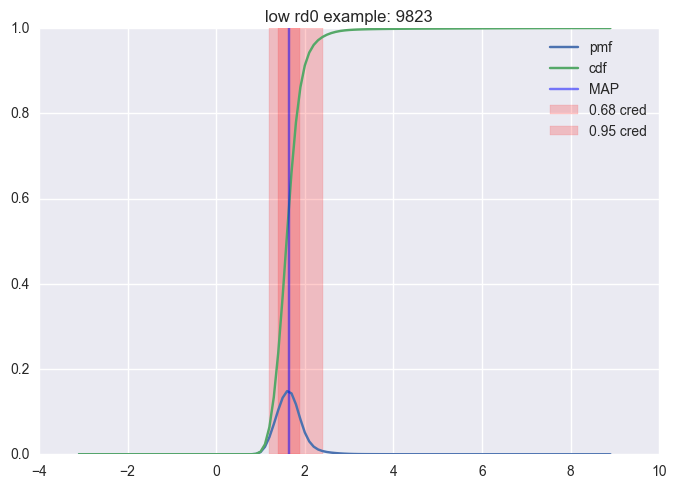

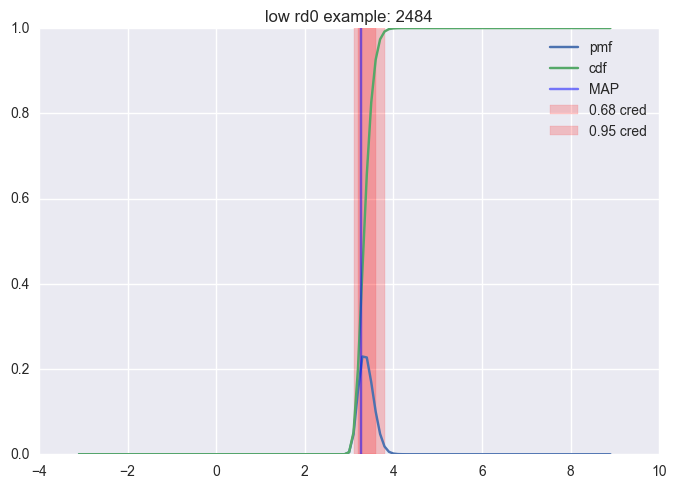

In [15]:
low_count_examples = chymo_src_data.sort_values(by="rd0").query("rd2 != 0 & rd1 != 0", engine="python").head(4)

for i in low_count_examples.index.values:
    pylab.figure()
    chymo_model.plot_cred_summary(chymo_model.estimate_ec50_cred(default_map, i))
    pylab.title("low rd0 example: %i" % i)
    pylab.legend()
    
low_count_examples

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


,name,sequence,rd0,rd1,rd2,rd3,rd4,rd5,rd6
2794,EEHEE_rd3_1407.pdb,STVTVGDKTFKADNPEKAKKLAQKFAKIYNLPVTQHGNKFTVQ,1596,0,0,0,1,0,0
9308,HEEH_rd3_1207.pdb_PG_hp,PNKIVKAFKKLLKTKQTANAKGAKIPPGNDKAAQAAFKAFTNA,378,15,14,0,0,0,0
3343,EEHEE_rd3_1084.pdb,KTVEVNGKKVTFDNPEAAQKFAEKAAKIYNLTVKEKNGTFTVK,383,131,0,0,0,0,0
3804,EHEE_rd3_0092.pdb_buryD,GSSTETYQFPTRKYAEQFAKEAKKRGKEVHVTQVGDTYKDKIK,444,97,118,0,0,0,0
7380,EEHEE_rd3_1772.pdb,TTFTIGNTTYEVPNPQEAQEAAEKAAKKLGLQVTVKNGTWKVE,268,60,56,76,0,0,0
5517,HEEH_rd3_0203.pdb,SREEAKKIEEAAKNGITTIRIGDTEYHFDTSDAAKEFAKELKK,571,78,293,894,505,1889,4242


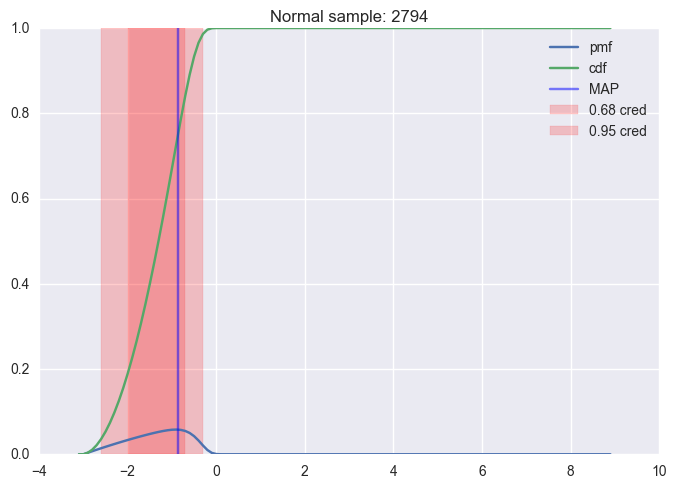

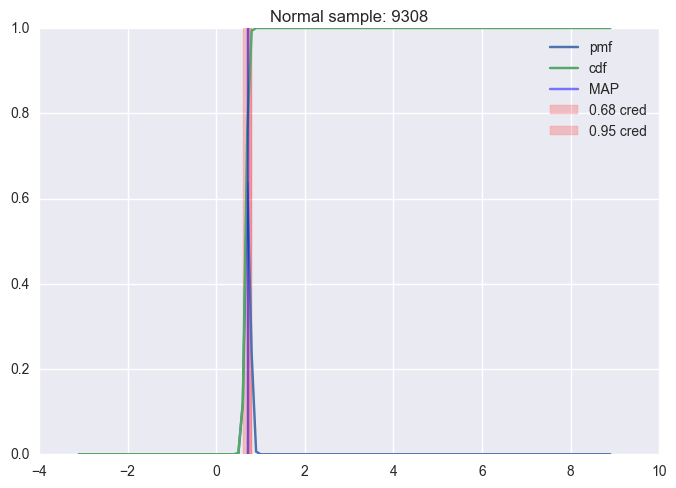

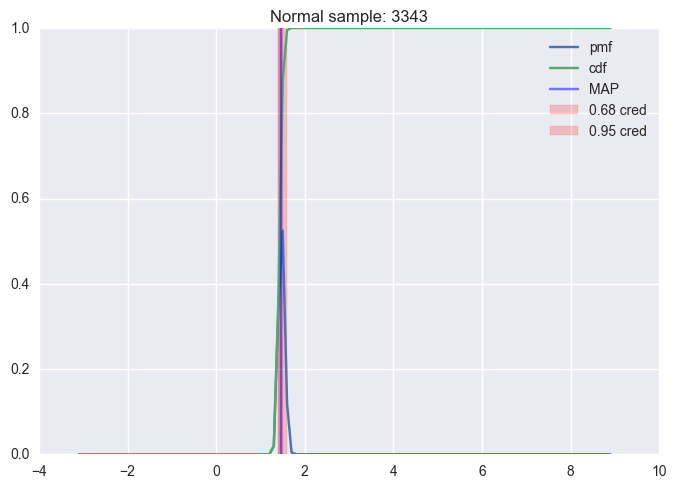

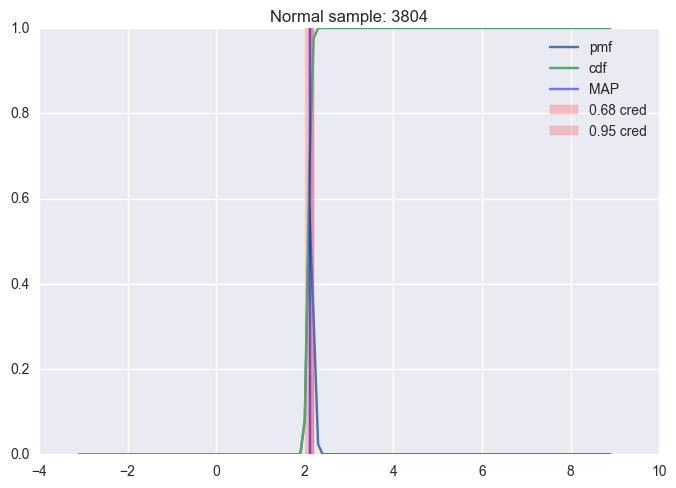

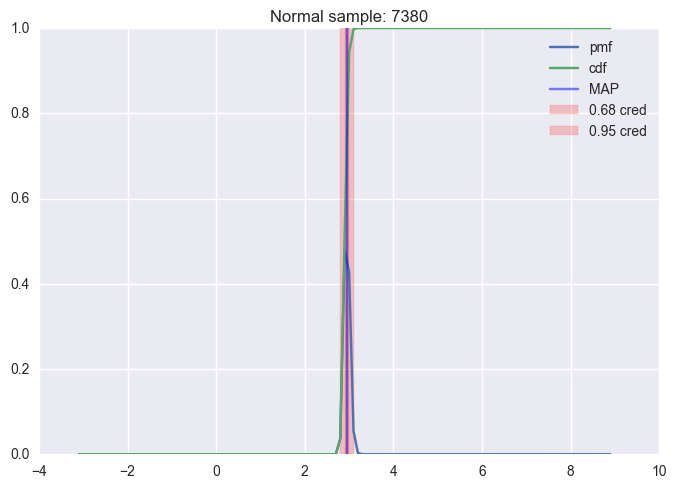

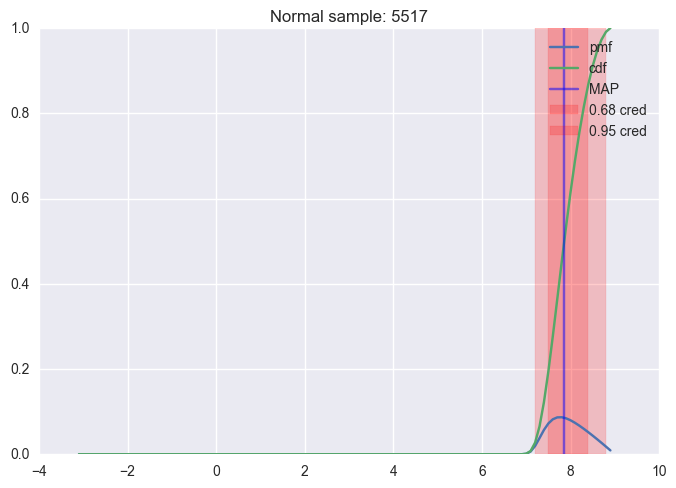

In [16]:
iorder = numpy.argsort(default_map["sel_ec50"])

isamples = iorder[::len(iorder)/5]


for i in isamples:
    pylab.figure()
    pylab.title("Normal sample: %s" % i)
    
    chymo_model.plot_cred_summary(chymo_model.estimate_ec50_cred(default_map, i))
    
    pylab.legend()
chymo_src_data.iloc[isamples]

rd0 > 200 & 0 < rd1 < rd0 * .2 & 0 < rd3 < 10 & 0 < rd4 < 10 & 0 < rd5


,name,sequence,rd0,rd1,rd2,rd3,rd4,rd5,rd6
8349,HEEH_rd3_0146.pdb_buryD,HAEDWAELDAKLNKPIKVQENGVTVTFQPGNKELAQKAYKAVF,1938,355,35,1,1,1,0
9829,EEHEE_rd3_0236.pdb_buryD,TTDHLNGQQYTFDNPEEAEKWAKKVAEEIGGTFEQHGTEYHVK,696,137,0,1,1,2,3


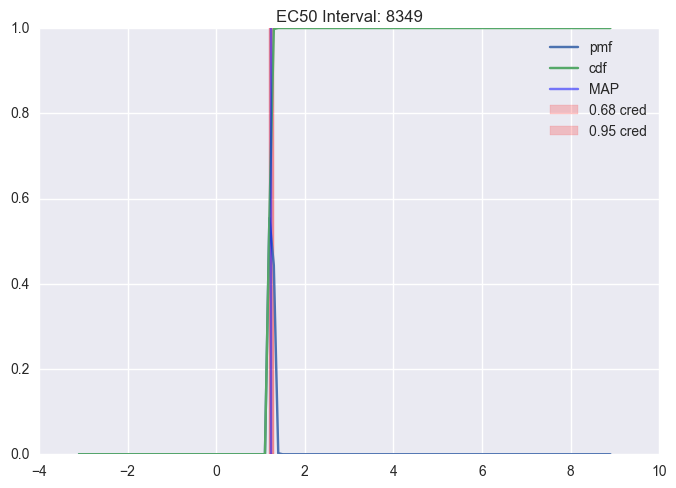

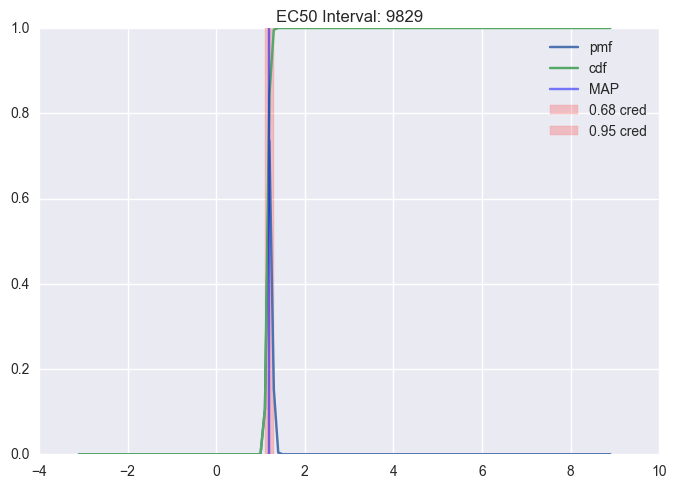

In [17]:
#lc_outlier_query = "rd0 > 200 & 0 < rd1 < 200 & 0 < rd2 < 10 & 0 < rd3 < 10 & 0 < rd4 < 10"
lc_outlier_query = "rd0 > 200 & 0 < rd1 < rd0 * .2 & 0 < rd3 < 10 & 0 < rd4 < 10 & 0 < rd5"
lc_outliers = chymo_src_data.query(lc_outlier_query, engine="python")

print(lc_outlier_query)
for i in lc_outliers.index.values:
    pylab.figure()
    pylab.title("EC50 Interval: %s" % i)
    chymo_model.plot_cred_summary(chymo_model.estimate_ec50_cred(default_map, i))
    
    pylab.legend()
    
lc_outliers

In [18]:
import ipywidgets

name                            HEEH_rd3_1353.pdb_PG_hp
sequence    PPEDIAEAAAKWGTPANLEKNGAQLTVPPGTKKAYQTLLAHIQ
rd0                                                 275
rd1                                                  95
rd2                                                  49
rd3                                                  83
rd4                                                   0
rd5                                                   0
rd6                                                   0
Name: 0, dtype: object


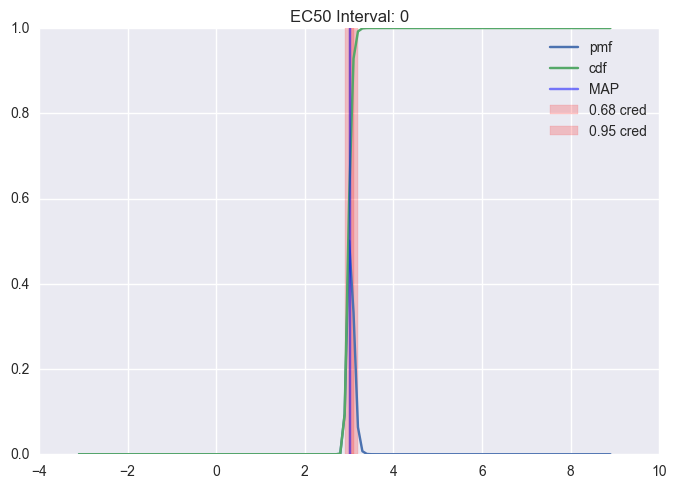

In [19]:
def plot_ec50_interval(i):
    pylab.figure()
    pylab.title("EC50 Interval: %s" % i)
    print(chymo_src_data.ix[i])
    chymo_model.plot_cred_summary(chymo_model.estimate_ec50_cred(default_map, i))
    
    pylab.legend()
    
ipywidgets.interact(plot_ec50_interval, i=ipywidgets.IntText())
pass

# Estimate posterior probability distributions

In [75]:
def model_selection_summary(self, params):
    def normed_pop(v):
        return v / v.sum()
    
    return {
        pkey : {
            "selected"  : self.population_data[pkey]["selected"],
            "selected_fraction" : normed_pop(self.population_data[pkey]["selected"].astype(float)),
            "pop_fraction" : normed_pop(self.model_populations[pkey]["selection_dist"](params))
        }
        for pkey in self.model_populations
    }

def model_outlier_summary(self, params):
    selection_summary = model_selection_summary(self, params)
    
    for v in selection_summary.values():
        cdf = stats.binom.cdf(
            v["selected"],
            n=v["selected"].sum(),
            p=v["pop_fraction"])
        sel_llh = numpy.log(numpy.where(cdf > .5, 1 - cdf, cdf) * 2)
        v["sel_log_likelihood"] = numpy.where(sel_llh != -numpy.inf, sel_llh, numpy.nan)
    
    return selection_summary

In [77]:
sel_sum = chymo_model.model_outlier_summary(default_map)

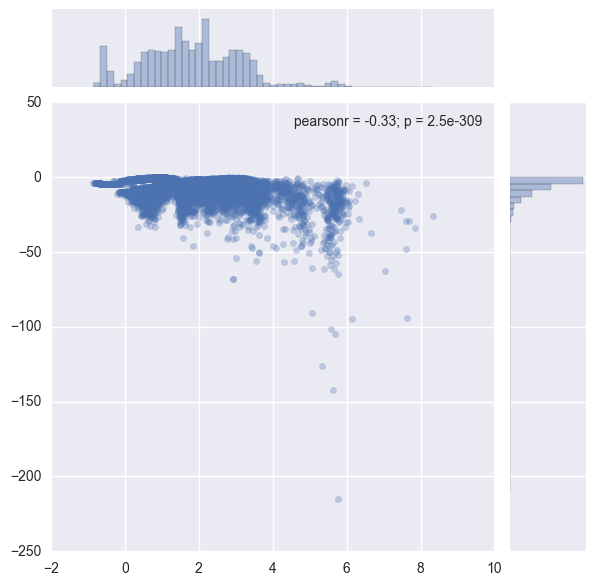

In [90]:
mean_llh = numpy.nanmean(
    numpy.stack([v["sel_log_likelihood"] for v in sel_sum.values()]),
    axis=0)
mean_llh[~numpy.isfinite(mllh)] = -250
seaborn.jointplot( default_map["sel_ec50"], mean_llh, joint_kws={"alpha" : .3})

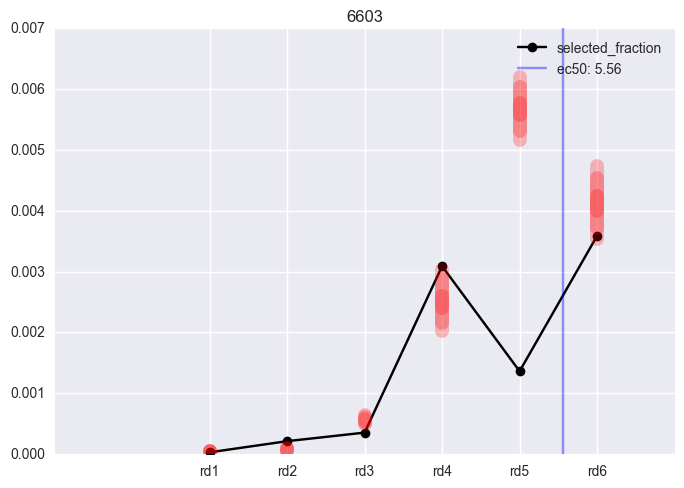

In [107]:
ordering = numpy.argsort(mean_llh)

@ipywidgets.interact(i_i=ipywidgets.IntSlider(max=len(ordering) - 1))
def plot_sum(i_i):
    
    i = ordering[i_i]
    
    pylab.title(i)
    pylab.xticks(
        [p["selection_level"] for p in chymo_model.population_data.values()],
        chymo_model.population_data.keys())
    pylab.xlim((-1, 7))
    
    pkeys = sorted(sel_sum.keys(), key=lambda k: chymo_model.population_data[k]["selection_level"]) 
    
    pylab.plot(
        [chymo_model.population_data[k]["selection_level"] for k in pkeys],
        [sel_sum[k]["selected_fraction"][i] for k in pkeys],
        "-o",
        color="black", label="selected_fraction")
    
    ec50_val = default_map["sel_ec50"][i]
    pylab.axvline(ec50_val, color="blue", alpha=.4, label="ec50: %.2f" % ec50_val)
    
    pylab.legend()
    
    for k in sel_sum:
        n = sel_sum[k]["selected"].sum()
        p = sel_sum[k]["pop_fraction"][i]
        sel_level = chymo_model.population_data[k]["selection_level"]
        bn = stats.binom(n=n, p=p)
        
        if p<=0:
            continue
        
        for ci in (.68, .95, .99):
            pylab.plot(
                [sel_level] * 2, bn.ppf([ci, 1-ci]) / n,
                linewidth=10, color="red", alpha=.25
            )
            
    
pass

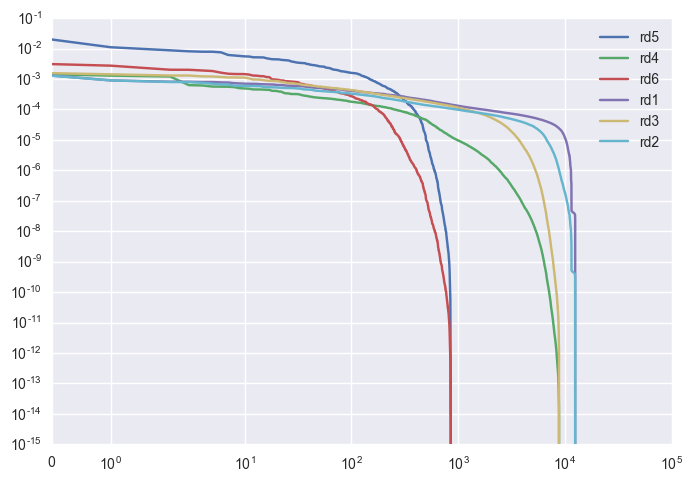

In [108]:
pylab.figure()
for k in chymo_model.model_populations:
    selection_dist = numpy.sort(chymo_model.model_populations[k]["selection_dist"](default_map))[::-1]
    pylab.plot(selection_dist, label=k)
pylab.yscale("log")
pylab.xscale("symlog")
pylab.legend()